# Machine Learning in Big Data

## Spark Session and DataSet

In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
import os
import sys

os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

spark = SparkSession.builder \
    .master("local") \
    .appName("anemia_modeling") \
    .getOrCreate()

sc = spark.sparkContext
sc

<SparkContext master=local appName=anemia_modeling>

In [2]:
spark_df = spark.read.csv("anemia.csv",header=True,inferSchema=True,sep=",")
spark_df.cache()

DataFrame[Gender: int, Hemoglobin: double, MCH: double, MCHC: double, MCV: double, Result: int]

In [3]:
spark_df.printSchema()

root
 |-- Gender: integer (nullable = true)
 |-- Hemoglobin: double (nullable = true)
 |-- MCH: double (nullable = true)
 |-- MCHC: double (nullable = true)
 |-- MCV: double (nullable = true)
 |-- Result: integer (nullable = true)



In [4]:
spark_df = spark_df.toDF(*[c.lower() for c in spark_df.columns])
spark_df.show(5)

+------+----------+----+----+----+------+
|gender|hemoglobin| mch|mchc| mcv|result|
+------+----------+----+----+----+------+
|     1|      14.9|22.7|29.1|83.7|     0|
|     0|      15.9|25.4|28.3|72.0|     0|
|     0|       9.0|21.5|29.6|71.2|     1|
|     0|      14.9|16.0|31.4|87.5|     0|
|     1|      14.7|22.0|28.2|99.5|     0|
+------+----------+----+----+----+------+
only showing top 5 rows



## Exploratory Data Analysis

In [5]:
spark_df.describe().show()

+-------+-------------------+------------------+------------------+------------------+-----------------+-------------------+
|summary|             gender|        hemoglobin|               mch|              mchc|              mcv|             result|
+-------+-------------------+------------------+------------------+------------------+-----------------+-------------------+
|  count|               1421|              1421|              1421|              1421|             1421|               1421|
|   mean| 0.5207600281491908| 13.41273750879661| 22.90562983814216|30.251231527093683|85.52378606615068| 0.4363124560168895|
| stddev|0.49974470888954664|1.9745456690995273|3.9693752800142135| 1.400897686250988|9.636701265962921|0.49610190149674077|
|    min|                  0|               6.6|              16.0|              27.8|             69.4|                  0|
|    max|                  1|              16.9|              30.0|              32.5|            101.6|                  1|


In [6]:
spark_df.select("gender","hemoglobin","mch","mchc","mcv","result").describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
gender,1421,0.5207600281491908,0.49974470888954664,0,1
hemoglobin,1421,13.41273750879661,1.9745456690995273,6.6,16.9
mch,1421,22.90562983814216,3.9693752800142135,16.0,30.0
mchc,1421,30.251231527093683,1.400897686250988,27.8,32.5
mcv,1421,85.52378606615068,9.636701265962921,69.4,101.6
result,1421,0.4363124560168895,0.49610190149674077,0,1


In [7]:
spark_df.filter(spark_df.hemoglobin>13).count()

776

In [8]:
spark_df.groupby("result").agg({"hemoglobin":"mean"}).show()

+------+------------------+
|result|   avg(hemoglobin)|
+------+------------------+
|     1|11.626290322580648|
|     0|14.795505617977518|
+------+------------------+



In [9]:
kor_data = spark_df.toPandas()

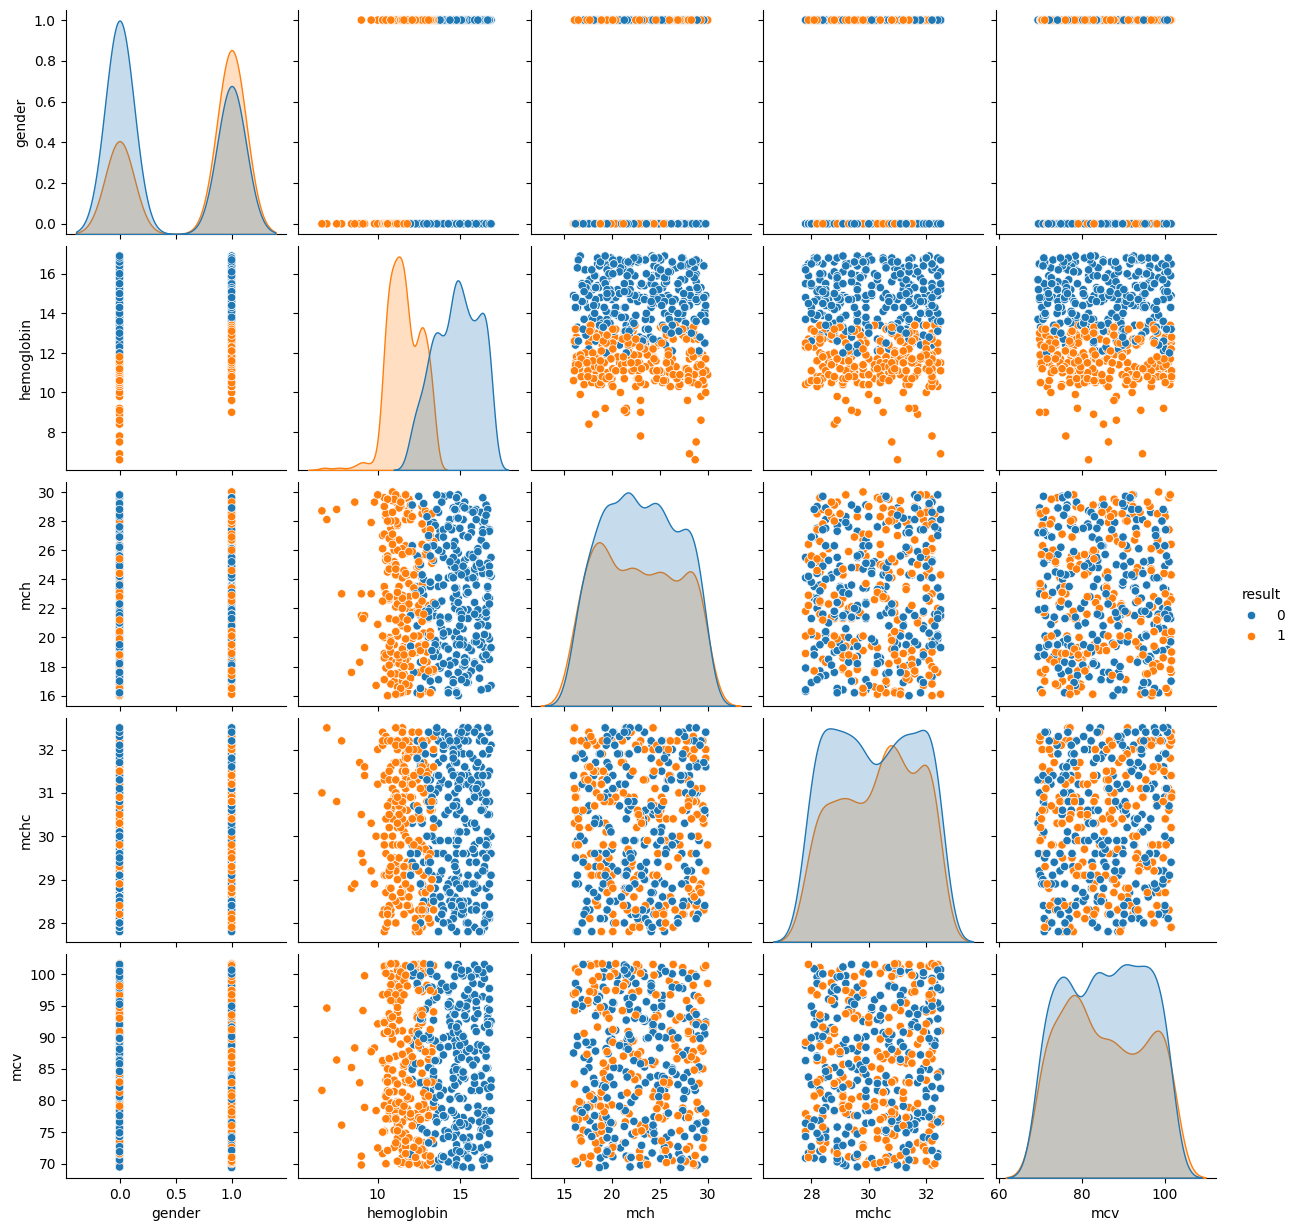

In [10]:
import seaborn as sns
sns.pairplot(kor_data, hue="result");

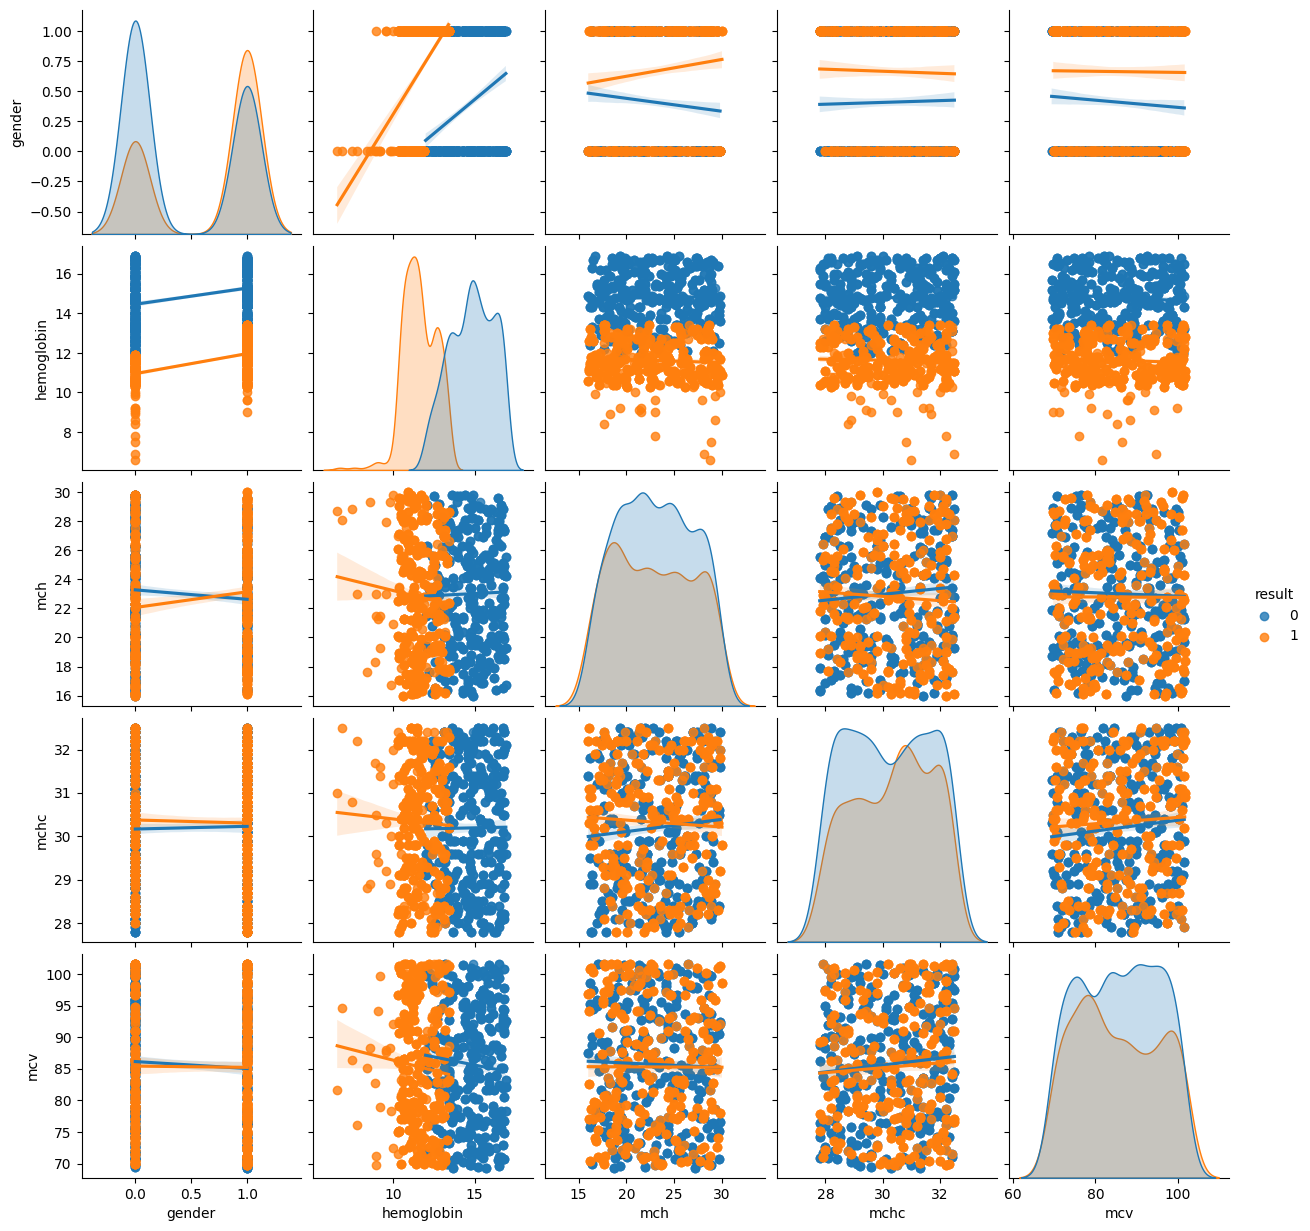

In [11]:
sns.pairplot(kor_data, vars = ["gender","hemoglobin","mch","mchc","mcv"], hue="result", kind = "reg");

## Data Preprocessing

In [12]:
type(spark_df)

pyspark.sql.dataframe.DataFrame

In [13]:
from pyspark.ml.feature import StringIndexer

stringIndexer = StringIndexer(inputCol = "result", outputCol = "label") ; stringIndexer

StringIndexer_98554484bbad

In [14]:
indexed = stringIndexer.fit(spark_df).transform(spark_df)

In [15]:
indexed.dtypes

[('gender', 'int'),
 ('hemoglobin', 'double'),
 ('mch', 'double'),
 ('mchc', 'double'),
 ('mcv', 'double'),
 ('result', 'int'),
 ('label', 'double')]

In [16]:
label_df = spark_df
label_df = indexed.withColumn("label",indexed["label"].cast("integer"))

In [17]:
label_df.dtypes

[('gender', 'int'),
 ('hemoglobin', 'double'),
 ('mch', 'double'),
 ('mchc', 'double'),
 ('mcv', 'double'),
 ('result', 'int'),
 ('label', 'int')]

In [18]:
spark_df

DataFrame[gender: int, hemoglobin: double, mch: double, mchc: double, mcv: double, result: int]

### Argument Variables

In [19]:
from pyspark.ml.feature import VectorAssembler, VectorIndexer

In [20]:
arg = ["gender","hemoglobin","mch","mchc","mcv"]

In [21]:
vectorAssembler = VectorAssembler(inputCols = arg, outputCol = "features")

In [22]:
va_df = vectorAssembler.transform(label_df)

In [23]:
final_df = va_df.select(["features","label"])

In [24]:
final_df.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[1.0,14.9,22.7,29...|    0|
|[0.0,15.9,25.4,28...|    0|
|[0.0,9.0,21.5,29....|    1|
|[0.0,14.9,16.0,31...|    0|
|[1.0,14.7,22.0,28...|    0|
|[0.0,11.6,22.3,30...|    1|
|[1.0,12.7,19.5,28...|    1|
|[1.0,12.7,28.5,28...|    1|
|[0.0,14.1,29.7,30...|    0|
|[1.0,14.9,25.8,31...|    0|
|[1.0,13.0,18.3,29...|    1|
|[0.0,16.7,27.5,28...|    0|
|[0.0,13.4,25.2,30...|    0|
|[0.0,14.7,28.9,31...|    0|
|[0.0,15.9,24.3,28...|    0|
|[1.0,14.0,25.5,32...|    0|
|[1.0,15.9,24.0,27...|    0|
|[1.0,12.3,21.8,27...|    1|
|[1.0,15.4,24.6,30...|    0|
|[0.0,13.6,19.3,31...|    0|
+--------------------+-----+
only showing top 20 rows



## Test & Train Split

In [25]:
splits = final_df.randomSplit([0.70,0.30])
train_df = splits[0]
test_df = splits[1]

## GBM

In [26]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml import Pipeline

In [27]:
gbm = GBTClassifier(featuresCol="features",labelCol="label",maxIter=10)

In [28]:
gbm_model = gbm.fit(train_df)

In [29]:
y_pred = gbm_model.transform(test_df)

In [30]:
ac = y_pred.select("label","prediction")

In [31]:
ac.filter(ac.label == ac.prediction).count() / ac.count()

1.0

In [32]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


evaluator = BinaryClassificationEvaluator()

paramGrid = (ParamGridBuilder()
            .addGrid(gbm.maxDepth, [2,4,6])
            .addGrid(gbm.maxBins, [20,30])
            .addGrid(gbm.maxIter, [10,20])
            .build())

cv = CrossValidator(estimator=gbm, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10)

In [33]:
pipeline = Pipeline(stages=[stringIndexer,vectorAssembler,cv])
pipe_model = pipeline.fit(spark_df)

In [34]:
y_pred = pipe_model.transform(spark_df)
ac = y_pred.select("label","prediction")

In [40]:
ac.filter(ac.label == ac.prediction).count() / ac.count()

1.0

In [41]:
evaluator.evaluate(y_pred)

1.0

In [37]:
type(pipe_model)

pyspark.ml.pipeline.PipelineModel

## Manuel Input

In [53]:
new_data = [(1, 14.9, 25.0, 32.0, 80.0),
            (0, 11.8, 26.0, 30.0, 78.0),]
new_data

[(1, 14.9, 25.0, 32.0, 80.0), (0, 11.8, 26.0, 30.0, 78.0)]

In [54]:
columns = ["gender", "hemoglobin", "mch", "mchc", "mcv"]

In [55]:
new_df = spark.createDataFrame(new_data, columns);new_df

DataFrame[gender: bigint, hemoglobin: double, mch: double, mchc: double, mcv: double]

In [56]:
vec_assembler = VectorAssembler(inputCols=["gender", "hemoglobin", "mch", "mchc", "mcv"], outputCol="new_features")
new_df = vec_assembler.transform(new_df)

In [57]:
predictions = pipe_model.transform(new_df)

In [58]:
predictions.select("features", "prediction").show()

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[1.0,14.9,25.0,32...|       0.0|
|[0.0,11.8,26.0,30...|       1.0|
+--------------------+----------+



## Model Serialization

In [38]:
import pyspark.ml

In [39]:
pipe_model.write().overwrite().save("C:/Users/asus/BigData/models/anemia_pipe_model")